# Implementing Proximal Policy Optimization 


In this notebook you will be implementing Proximal Policy Optimization algorithm, 
scaled up version of which was used to train [OpenAI Five](https://openai.com/blog/openai-five/) 
to [win](https://openai.com/blog/how-to-train-your-openai-five/) against the
world champions in Dota 2.
You will be solving a continuous control environment on which it may be easier and faster 
to train an agent, however note that PPO here may not be the best algorithm as, for example,
Deep Deterministic Policy Gradient and Soft Actor Critic may be more suited 
for continuous control environments. To run the environment you will need to install 
[pybullet-gym](https://github.com/benelot/pybullet-gym) which unlike MuJoCo 
does not require you to have a license.

To install the library:

In [1]:
# !git clone https://github.com/benelot/pybullet-gym lib/pybullet-gym
# !pip install -e lib/pybullet-gym

#### Attention
####I installed pybullet=2.5.9 after previous Cell

The overall structure of the code is similar to the one in the A2C optional homework, but don't worry if you haven't done it, it should be relatively easy to figure it out. 
First, we will create an instance of the environment. 
We will normalize the observations and rewards, but before that you will need a wrapper that will 
write summaries, mainly, the total reward during an episode. You can either use one for `TensorFlow` 
implemented in `atari_wrappers.py` file from the optional A2C homework, or implement your own. 

In [2]:
import gym 
# import pybulletgym

env = gym.make("HalfCheetah-v2")
print("observation space: ", env.observation_space,
      "\nobservations:", env.reset())
print("action space: ", env.action_space, 
      "\naction_sample: ", env.action_space.sample())

observation space:  Box(17,) 
observations: [-0.01573133  0.04474833  0.04011408  0.00285162  0.02471707 -0.07554306
 -0.02869226 -0.02982527 -0.03624167 -0.03613526 -0.14976687  0.06476579
 -0.14698568  0.01068631  0.03696603  0.03843252 -0.20845177]
action space:  Box(6,) 
action_sample:  [ 0.64401394  0.8359449   0.04474253  0.4214272  -0.12282886 -0.8271604 ]


The normalization wrapper will subtract running mean from observations and rewards and divide 
the resulting quantities by the  running variances.

In [3]:
from mujoco_wrappers import Normalize

env = gym.make("HalfCheetah-v2")
env2 = gym.make("HalfCheetah-v2")
env.unwrapped.seed(0);

Next, you will need to define a model for training. We suggest that you use two separate networks: one for policy
and another for value function. Each network should be a 3-layer MLP with 64 hidden units, $\mathrm{tanh}$ 
activation function, kernel matrices initialized with orthogonal initializer with parameter $\sqrt{2}$
and biases initialized with zeros. 

Our policy distribution is going to be multivariate normal with diagonal covariance. 
The network from above will predict the mean, and the covariance should be represented by a single 
(learned) vector of size 6 (corresponding to the dimensionality of the action space from above). 
You should initialize this vector to zero and take the exponent of it to always
have a non-negative quantity. 

Overall the model should return three things: predicted mean of the distribution, variance vector, 
value function. 

In [4]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
                
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class PolicyNetwork(nn.Module):
    
    def __init__(self, shape_in, action_shape, hidden_size=64):
        super(PolicyNetwork, self).__init__()
        self.dense1 = layer_init(nn.Linear(shape_in, hidden_size))
        self.dense2 = layer_init(nn.Linear(hidden_size, hidden_size))
        self.dense3_mu = layer_init(nn.Linear(hidden_size, action_shape), std=0.01)
        self.dense3_std = layer_init(nn.Linear(hidden_size, action_shape), std=0.0)
        
    def forward(self, inputs):
        hid = torch.tanh(self.dense2(torch.tanh(self.dense1(inputs))))
        mu = self.dense3_mu(hid)
        sigma = torch.exp(self.dense3_std(hid))
        return mu, sigma

class ValueNetwork(nn.Module):
    
    def __init__(self, shape_in, hidden_size=64):
        super(ValueNetwork, self).__init__()
        self.dense1 = layer_init(nn.Linear(shape_in, hidden_size))
        self.dense2 = layer_init(nn.Linear(hidden_size, hidden_size))
        self.dense3 = layer_init(nn.Linear(hidden_size, 1), std =1.0)
    def forward(self, inputs):
        hid = torch.tanh(self.dense2(torch.tanh(self.dense1(inputs))))
        return self.dense3(hid)
    
    
class Network(nn.Module):
    def __init__(self, shape_in, action_shape, hidden_size=64):
        super(Network, self).__init__()
        self.policy = PolicyNetwork(shape_in, action_shape, hidden_size)
        self.value = ValueNetwork(shape_in, hidden_size)
    def forward(self, inputs):
        return self.policy(inputs), self.value(inputs)

This model will be wrapped by a `Policy`. The policy can work in two modes, but in either case 
it is going to return dictionary with string-type keys. The first mode is when the policy is 
used to sample actions for a trajectory which will later be used for training. In this case 
the flag `training` passed to `act` method is `False` and the method should return 
a `dict` with the following keys: 

* `"actions"`: actions to pass to the environment
* `"log_probs"`: log-probabilities of sampled actions
* `"values"`: value function $V^\pi(s)$ predictions.

We don't need to use the values under these keys for training, so all of them should be of type `np.ndarray`.

When `training` is `True`, the model is training on a given batch of observations. In this
case it should return a `dict` with the following keys

* `"distribution"`: an instance of multivariate normal distribution (`torch.distributions.MultivariateNormal` or `tf.distributions.MultivariateNormalDiag`)
* `"values"`: value function $V^\pi(s)$ prediction.

The distinction about the modes comes into play depending on where the policy is used: if it is called from `EnvRunner`, 
the `training` flag is `False`, if it is called from `PPO`, the `training` flag is `True`. These classed 
will be described below. 

In [5]:
class Policy:
    def __init__(self, model):
        self.model = model
    
    def act(self, inputs, training=False):
        inputs = torch.tensor(inputs, dtype=torch.float32)
        (mus, sigmas), values = self.model(inputs)
        dist = torch.distributions.MultivariateNormal(mus, torch.diag_embed(sigmas, 0))
        actions = dist.sample()
        log_probs = dist.log_prob(actions)
        if training:
            return {'distribution': dist,
                    'values': values}
        else:
            return {'actions': actions.detach().numpy(),
                    'log_probs': log_probs.detach().numpy(),
                    'values': values.detach().numpy()}

We will use `EnvRunner` to perform interactions with an environment with a policy for a fixed number of timesteps. Calling `.get_next()` on a runner will return a trajectory &mdash; dictionary 
containing keys

* `"observations"`
* `"rewards"` 
* `"resets"`
* `"actions"`
* all other keys that you defined in `Policy`,

under each of these keys there is a `np.ndarray` of specified length $T$ &mdash; the size of partial trajectory. 

Additionally, before returning a trajectory this runner can apply a list of transformations. 
Each transformation is simply a callable that should modify passed trajectory in-place.

In [6]:
class AsArray:
    """ 
       Converts lists of interactions to ndarray.
    """
    def __call__(self, trajectory):
      # Modify trajectory inplace. 
      for k, v in filter(lambda kv: kv[0] != "state",
                         trajectory.items()):
        trajectory[k] = np.asarray(v)

In [7]:
import numpy as np
from runners import EnvRunner

class DummyPolicy:
    def act(self, inputs, training=False):
        assert not training
        return {"actions": np.random.randn(6), "values": np.nan}

runner = EnvRunner(env, DummyPolicy(), 30,
                   transforms=[AsArray()])
trajectory = runner.get_next()

{k: v.shape for k, v in trajectory.items() if k != "state"}

{'actions': (30, 6),
 'values': (30,),
 'observations': (30, 17),
 'rewards': (30,),
 'resets': (30,)}

You will need to implement the following two transformations. 

The first is `GAE` that implements [Generalized Advantage Estimator](https://arxiv.org/abs/1506.02438).
In it you should add two keys to the trajectory: `"advantages"` and `"value_targets"`. In GAE the advantages
$A_t^{\mathrm{GAE}(\gamma,\lambda)}$ are essentially defined as the exponential 
moving average with parameter $\lambda$ of the regular advantages 
$\hat{A}^{(T)}(s_t) = \sum_{l=0}^{T-1-t} \gamma^l r_{t+l} + \gamma^{T} V^\pi(s_{T}) - V^\pi(s_t)$. 
The exact formula for the computation is the following

$$
A_{t}^{\mathrm{GAE}(\gamma,\lambda)} = \sum_{l=0}^{T-1-t} (\gamma\lambda)^l\delta_{t + l}^V, \, t \in [0, T)
$$
where $\delta_{t+l}^V = r_{t+l} + \gamma V^\pi(s_{t+l+1}) - V^\pi(s_{t+l})$. You can look at the 
derivation (formulas 11-16) in the paper. Don't forget to reset the summation on terminal
states as determined by the flags `trajectory["resets"]`. You can use `trajectory["values"]`
to get values of all observations except the most recent which is stored under 
 `trajectory["state"]["latest_observation"]`. For this observation you will need to call the policy 
 to get the value prediction.

Once you computed the advantages, you can get the targets for training the value function by adding 
back values:
$$
\hat{V}(s_{t+l}) = A_{t+l}^{\mathrm{GAE}(\gamma,\lambda)} + V(s_{t + l}),
$$
where $\hat{V}$ is a tensor of value targets that are used to train the value function. 

In [8]:
class GAE:
    """ Generalized Advantage Estimator. """
    def __init__(self, policy, gamma=0.99, lambda_=0.95):
        self.policy = policy
        self.gamma = gamma
        self.lambda_ = lambda_
    
    def __call__(self, trajectory):
        value_target = policy.act(trajectory['state']['latest_observation'])['values'][0]
        env_steps = trajectory['state']['env_steps']
        rewards = torch.tensor(trajectory['rewards'], dtype=torch.float32)
        dones = torch.tensor(trajectory['resets'], dtype=torch.float32)
        is_not_done = 1 - dones
        trajectory['values'] = torch.tensor(trajectory['values'],dtype=torch.float32)
        trajectory['advantages'] = []
        trajectory['value_targets'] = []
        gae = 0
        for step in reversed(range(env_steps)):
            if step==env_steps - 1:
                delta = rewards[step] + self.gamma*value_target*is_not_done[step] - trajectory['values'][step]
            else:
                delta = rewards[step] + self.gamma*trajectory['values'][step + 1]*is_not_done[step] -\
                        trajectory['values'][step]
            
            gae = delta + self.gamma*self.lambda_*is_not_done[step]*gae
            trajectory['advantages'].insert(0, gae)
            trajectory['value_targets'].insert(0, gae + trajectory['values'][step])
        trajectory['advantages'] = torch.tensor(trajectory['advantages'], dtype=torch.float32)
        trajectory['value_targets'] = torch.tensor(trajectory['value_targets'], dtype=torch.float32)

The main advantage of PPO over simpler policy based methods like A2C is that it is possible
to train on the same trajectory for multiple gradient steps. The following class wraps 
an `EnvRunner`. It should call the runner to get a trajectory, then return minibatches 
from it for a number of epochs, shuffling the data before each epoch.

In [9]:
class TrajectorySampler:
    """ Samples minibatches from trajectory for a number of epochs. """
    def __init__(self, runner, num_epochs, num_minibatches, transforms=None):
        self.runner = runner
        self.num_epochs = num_epochs
        self.num_minibatches = num_minibatches
        self.transforms = transforms or []
        self.minibatch_count = 0
        self.epoch_count = 0
        self.trajectory = self.runner.get_next()
        for transform in self.transforms:
                transform(self.trajectory)
    def shuffle_trajectory(self):
        """ Shuffles all elements in trajectory.
            Should be called at the beginning of each epoch.
        """
        pass
    
    def get_next(self):
        """ Returns next minibatch.  """
        if self.epoch_count==self.num_epochs:
            self.trajectory = self.runner.get_next()
            for transform in self.transforms:
                transform(self.trajectory)
            self.epoch_count = 0
        minibatch_dict = {}
        rand_inds = np.random.randint(0, self.trajectory['state']['env_steps'], self.num_minibatches)
        for key, value in self.trajectory.items():
            if key!='state':
                if len(value)==2:
                    minibatch_dict[key] = self.trajectory[key][rand_inds,:]
                else:
                    minibatch_dict[key] = self.trajectory[key][rand_inds]
        self.epoch_count += 1
        return minibatch_dict

A common trick to use with GAE is to normalize advantages, the following transformation does that. 

In [10]:
class NormalizeAdvantages:
    """ Normalizes advantages to have zero mean and variance 1. """
    def __call__(self, trajectory):
        adv = trajectory["advantages"]
        adv = (adv - adv.mean()) / (adv.std() + 1e-8)
        trajectory["advantages"] = adv

Finally, we can create our PPO runner. 

In [11]:
### Attention: 
#I changed HERE LOOK (env, policy, num_runner_steps=2048, gamma=0.99, lambda_=0.95,
#num_epochs=10, num_minibatches=32)

def make_ppo_runner(env, policy, num_runner_steps=1024,
                    gamma=0.99, lambda_=0.95, 
                    num_epochs=16, num_minibatches=64):
    """ Creates runner for PPO algorithm. """
    runner_transforms = [AsArray(),
                         GAE(policy, gamma=gamma, lambda_=lambda_)]
    runner = EnvRunner(env, policy, num_runner_steps, 
                       transforms=runner_transforms)
    sampler_transforms = [NormalizeAdvantages()]
    sampler = TrajectorySampler(runner, num_epochs=num_epochs, 
                                num_minibatches=num_minibatches,
                                transforms=sampler_transforms)
    return sampler

In [12]:
model = Network(shape_in=17, action_shape=6)
policy = Policy(model)
runner = make_ppo_runner(env, policy)

In the next cell you will need to implement Proximal Policy Optimization algorithm itself. The algorithm
modifies the typical policy gradient loss in the following way:

$$
J_{\pi}(s, a) = \frac{\pi_\theta(a|s)}{\pi_\theta^{\text{old}}(a|s)} \cdot A^{\mathrm{GAE}(\gamma,\lambda)}(s, a)
$$

$$
J_{\pi}^{\text{clipped}}(s, a) = \mathrm{clip}\left(
\frac{\pi_\theta(a|s)}{\pi_{\theta^{\text{old}}}(a|s)},
1 - \text{cliprange}, 1 + \text{cliprange}\right)\cdot A^{\mathrm{GAE(\gamma, \lambda)}}(s)\\
$$

$$
L_{\text{policy}} = -\frac{1}{T}\sum_{l=0}^{T-1}\min\left(J_\pi(s_{t + l}, a_{t + l}), J_{\pi}^{\text{clipped}}(s_{t + l}, a_{t + l})\right).
$$

The value loss is also modified:

$$
L_{V}^{\text{clipped}} = \frac{1}{T}\sum_{l=0}^{T-1} \max(l^{simple}(s_{t + l}), l^{clipped}(s_{t + l}))
$$
, where $l^{simple}$ is your standard critic loss
$$
l^{simple}(s_{t + l}) = [V_\theta(s_{t+l}) - G(s_{t + l})]^2
$$

and $l^{clipped}$ is a clipped version that limits large changes of the value function:
$$
l^{clipped}(s_{t + l}) = [
V_{\theta^{\text{old}}}(s_{t+l}) +
\text{clip}\left(
V_\theta(s_{t+l}) - V_{\theta^\text{old}}(s_{t+l}),
-\text{cliprange}, \text{cliprange}
\right) - G(s_{t + l})] ^ 2
$$

In [13]:
class PPO:
    def __init__(self, policy, optimizer,
                   cliprange=0.2,
                   value_loss_coef=0.25,
                   max_grad_norm=0.5):
        self.policy = policy
        self.optimizer = optimizer
        self.cliprange = cliprange
        self.value_loss_coef = value_loss_coef
        # Note that we don't need entropy regularization for this env.
        self.max_grad_norm = max_grad_norm
    
    def policy_loss(self, trajectory, act):
        """ Computes and returns policy loss on a given trajectory. """
        log_probs_all = act['distribution'].log_prob(torch.tensor(trajectory['actions']))
        log_old_probs_all = torch.tensor(trajectory['log_probs'])
        ratio = (log_probs_all - log_old_probs_all).exp()
        J_pi = ratio*trajectory['advantages'].detach()
        self.advantages_np = trajectory['advantages'].detach().mean().numpy()
        J_pi_clipped = torch.clamp(ratio, 1 - self.cliprange, 1 + self.cliprange)*trajectory['advantages'].detach()
        return -torch.mean(torch.min(J_pi, J_pi_clipped))
      
    def value_loss(self, trajectory, act):
        """ Computes and returns value loss on a given trajectory. """
        self.values_np = trajectory['values'].detach().mean().cpu().numpy()
        L_simple = (act['values'] - trajectory['value_targets'].detach())**2
        L_clipped = (trajectory['values'] + torch.clamp(act['values'] - trajectory['values'],
                    -self.cliprange, self.cliprange) - trajectory['value_targets'].detach())**2
        self.values_loss_np = torch.mean(torch.max(L_simple, L_clipped)).detach().numpy()
        return torch.mean(torch.max(L_simple, L_clipped))
    
      
    def loss(self, trajectory):
        act = self.policy.act(trajectory["observations"], training=True)
        policy_loss = self.policy_loss(trajectory, act)
        value_loss = self.value_loss(trajectory, act)
        self.policy_loss_np = policy_loss.detach().numpy()
        self.value_loss_np = value_loss.detach().numpy()
        self.ppo_loss_np = self.policy_loss_np + self.value_loss_coef * self.value_loss_np
        return policy_loss + self.value_loss_coef * value_loss
      
    def step(self, trajectory):
        """ Computes the loss function and performs a single gradient step. """
        self.optimizer.zero_grad()
        self.loss(trajectory).backward()
        torch.nn.utils.clip_grad_norm_(policy.model.parameters(), self.max_grad_norm)
        self.optimizer.step()
        self.total_norm = 0
        for p in policy.model.parameters():
            param_norm = p.grad.data.norm(2)
            self.total_norm += param_norm.item() ** 2
        self.total_norm = self.total_norm ** (1. / 2)

Now everything is ready to do training. In one million of interactions it should be possible to 
achieve the total raw reward of about 1500. You should plot this quantity with respect to 
`runner.step_var` &mdash; the number of interactions with the environment. It is highly 
encouraged to also provide plots of the following quantities (these are useful for debugging as well):

* [Coefficient of Determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) between 
value targets and value predictions
* Entropy of the policy $\pi$
* Value loss
* Policy loss
* Value targets
* Value predictions
* Gradient norm
* Advantages

For optimization it is suggested to use Adam optimizer with linearly annealing learning rate 
from 3e-4 to 0 and epsilon 1e-5.

In [14]:
def evaluate(env2, agent, n_games=1, render=False):
    """Plays an a game from start till done, returns per-game rewards """
    agent.train(False)
    game_rewards = []
    done_counter = 0
    for _ in range(n_games):
        state = env.reset()
        total_reward = 0
        while True:
            if render:
                env.render()
            state = torch.tensor(state, dtype=torch.float32)
            (mus, sigmas), _ = agent(state)
            dist = torch.distributions.MultivariateNormal(mus, torch.diag_embed(sigmas, 0))
            action = dist.sample().cpu().detach().numpy()
            state, reward, done, info = env.step(action)
            total_reward += reward
            if done:
                break
        game_rewards.append(total_reward)
#     env.close()
#     env.reset()
    agent.train(True)
    return game_rewards

In [15]:
model = Network(shape_in=17, action_shape=6)
policy = Policy(model)
runner = make_ppo_runner(env, policy)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, eps=1e-05)

In [16]:
from IPython.display import clear_output
from tqdm import trange
import matplotlib.pyplot as plt

In [17]:
def plot_tools(legend, position, data_y):
    plt.subplot(2,4,position)
    plt.plot(data_y, label=legend)
    plt.title(legend); plt.grid(); plt.legend() 
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

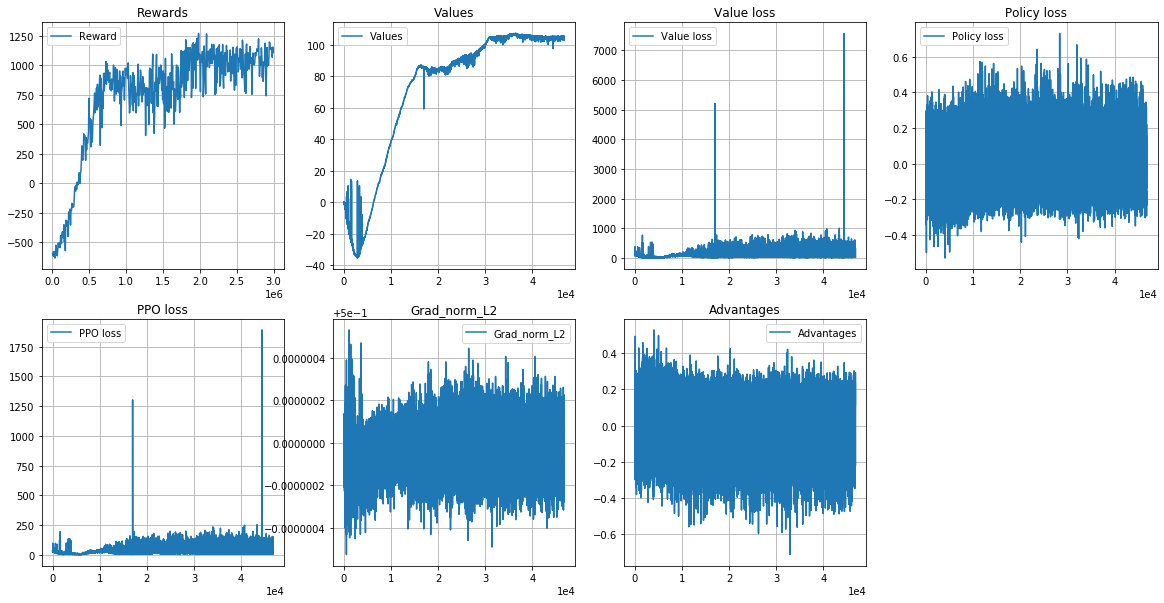

In [18]:
ppo = PPO(policy, optimizer) 
num_steps = []
current_number_of_steps = 0
rewards = []
value_losses = []
policy_losses = []
values = []
grad_norms = []
advantages = []
ppo_losses = []

MAX_UPDATES = 3_000_900
i = 0
while current_number_of_steps<=MAX_UPDATES:
    i += 1
    trajectory = runner.get_next()
    ppo.step(trajectory)
    current_number_of_steps = runner.runner.step_var
    ppo.optimizer.param_groups[0]['lr'] = (1.0 - (current_number_of_steps - 1.0)/MAX_UPDATES)*3e-4
    value_losses.append(ppo.values_loss_np)
    policy_losses.append(ppo.policy_loss_np)
    values.append(ppo.values_np)
    grad_norms.append(ppo.total_norm)
    advantages.append(ppo.advantages_np)
    ppo_losses.append(ppo.ppo_loss_np)
    if i%100==0:
        clear_output(True)
        num_steps.append(runner.runner.step_var)
        
        rewards.append(np.mean(evaluate(env2, model, n_games=5)))
        
        plt.figure(figsize=[20,10])
        
        plt.subplot(2,4,1)
        plt.plot(num_steps, rewards, label='Reward')
        plt.title("Rewards"); plt.grid(); plt.legend()
        plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

        plot_tools('Values', 2, values)
        plot_tools('Value loss', 3, value_losses)
        plot_tools('Policy loss', 4, policy_losses)
        plot_tools('PPO loss', 5, ppo_losses)
        plot_tools('Grad_norm_L2', 6, grad_norms) 
        plot_tools('Advantages', 7, advantages)

        plt.show()

In [19]:
print('In the end', np.mean(evaluate(env2, model, n_games=10, render=True)))

Creating window glfw
In the end 1093.4526369867322


In [20]:
env2.close()

In [23]:
env._max_episode_steps

1000